# Logistic Regression Lab 6 NLP
### OUTLINE
1. Data Preprocessing
    * Exploring data
    * Handle missing values
    * Feature engineering
    * Normalization
2. Logistic Regression Model
3. Result

In [726]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import gdown
import string
from PIL import Image

In [727]:
based_url = 'https://drive.google.com/uc?id='
zip_path = 'titanic.zip'
dir_name = 'titanic'
if not os.path.exists(zip_path):
    url = f'{based_url}1EayXSkygJXrt3deJXuFQLupGqZLUHPU2'
    gdown.download(url, zip_path, quiet=False)
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dir_name)
        print('Extracted')
file_path = f'{dir_name}/train.csv'
df = pd.read_csv(file_path)
test = pd.read_csv(f'{dir_name}/test.csv')
passenger_id = test['PassengerId']

## 1. Data Preprocessing

### Exploring data

In [728]:
def check_range(df1, df2, cols, name1, name2):
    print(f'{name1} dif {name2}')
    for col in cols:
        set1 = set(df1[col].unique())
        set2 = set(df2[col].unique())
        diff = list(set1.difference(set2))
        if len(diff) > 0:
            print(f'{col}: {diff}')

# all_cols = set(df.columns) - set(['SalePrice'])
all_cols = set(df.select_dtypes(include=[object]).columns) - set(['Name', 'Ticket', 'Cabin'])
check_range(df, test, all_cols, name1='train', name2='test')
check_range(test, df, all_cols, name1='test', name2='train')

train dif test
Embarked: [nan]
test dif train


In [729]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [730]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Feature Engineering

* Add column Title: title extracted from names + change different ways to one representation
* Nominal: one hot encoding
* Ordinal: label encoding

### Handle missing values
* Cabin: missing a lot since only first class ticket has cabin -> drop
* Age: impute based on median age of ppl having the same family size
* Fare: Median since negative skew
* Embarkedd: Mode

In [731]:
def find_nulls(df):
    null_cols = {}
    for col in df.columns:
        null_cols[col] = round(int(df[col].isnull().sum()) / len(df) * 100,2)

    null_cols = {k: v for k, v in null_cols.items() if v > 0}
    return null_cols

def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    return np.nan

title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']

def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

def custom_feature(df_ref):
    df_ref['FamilySize'] = df_ref['SibSp'] + df_ref['Parch']
    df_ref['Title'] = df_ref['Name'].map(lambda x: substrings_in_string(x, title_list))
    df_ref['Title'] = df_ref.apply(replace_titles, axis=1)
    family_sizes = sorted(df_ref['FamilySize'].unique())
    mean_ages = [x for x in df_ref.groupby('FamilySize')['Age'].median()]
    df_ref['Age'] = df_ref.apply(
        lambda x: mean_ages[family_sizes.index(x['FamilySize'])] if np.isnan(x['Age']) else x['Age'], axis=1)
    df_ref['Age'] = df_ref['Age'].fillna(df_ref['Age'].median())
    df_ref['Embarked'] = df_ref['Embarked'].fillna(df_ref['Embarked'].mode()[0])
    df_ref['Fare'] = df_ref['Fare'].fillna(df_ref['Fare'].median())



In [732]:
print(find_nulls(df))
print(find_nulls(test))

{'Age': 19.87, 'Cabin': 77.1, 'Embarked': 0.22}
{'Age': 20.57, 'Fare': 0.24, 'Cabin': 78.23}


In [733]:
custom_feature(df)
custom_feature(test)
print(find_nulls(df))
print(find_nulls(test))
# survived = df['Survived']
# df.drop('Survived', axis=1, inplace=True)
# df_combined = pd.concat([df, test], axis=0)
# custom_feature(df_combined)
# print(find_nulls(df_combined))


{'Cabin': 77.1}
{'Cabin': 78.23}


In [734]:
from sklearn.preprocessing import LabelEncoder

survived = df['Survived']
df.drop('Survived', axis=1, inplace=True)
df_combined = pd.concat([df, test], axis=0)
# drop unnecessary columns
df_combined.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1, inplace=True)

# encoding categorical variables
df_combined = pd.get_dummies(df_combined,columns=['Sex'],drop_first=True, dtype=int)

label_enc = LabelEncoder()
ordinal_cols = ['Title', 'Embarked']
for col in ordinal_cols:
    df_combined[col] = label_enc.fit_transform(df_combined[col])

df_combined.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,FamilySize,Title,Sex_male
0,3,22.0,1,0,7.2500,2,1,2,1
1,1,38.0,1,0,71.2833,0,1,3,0
2,3,26.0,0,0,7.9250,2,0,1,0
3,1,35.0,1,0,53.1000,2,1,3,0
4,3,35.0,0,0,8.0500,2,0,2,1


### Normalization
After plotting the historgams, I see that:
* Age: normal distribution 
* Fare: positive skew -> min max scaler

In [735]:
num_features_std = ['Age']
num_features_minmax = ['Fare']

preprocessor = ColumnTransformer([
    ('std', StandardScaler(), num_features_std),
    ('minmax', MinMaxScaler(), num_features_minmax)
], remainder='passthrough')  # Keep other columns unchanged

df = df_combined.iloc[:len(df)]
test = df_combined.iloc[len(df):]

df = preprocessor.fit_transform(df)
test = preprocessor.transform(test)
transformed_columns = num_features_std + num_features_minmax  # Only transformed columns

df_combined_scaled = np.concatenate([df, test], axis=0)

other_columns = [col for col in df_combined.columns if col not in transformed_columns]  # Unchanged columns
new_column_order = transformed_columns + other_columns  

df_combined_scaled = pd.DataFrame(df_combined_scaled, columns=new_column_order)

### Train test split

In [ ]:
def print_shapes(lst):
    for x in lst:
        print(x.shape)

#get back
df2 = df_combined_scaled[:len(df)].to_numpy()
test2 = df_combined_scaled[len(df):].to_numpy()
survived_np = survived.to_numpy().reshape(-1,1)

X_train, X_val, Y_train, Y_val = train_test_split(df2, survived_np, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = X_train.T, X_val.T, Y_train.T, Y_val.T
print_shapes([X_train, Y_train, X_val, Y_val])

(9, 712)
(1, 712)
(9, 179)
(1, 179)


## 2. Logistic Regression Model

Best: 
* W: init using normal distriution
* Optimizer: SGD learning_rate 0.001
* Regularizer: L2 lambda 0.7
* Iterations: 40k

In [737]:
print(np.min(df_combined_scaled), np.max(df_combined_scaled))

-2.256112928775439 10.0


In [738]:
def plot_costs(costs, val_costs):
    plt.plot(range(len(costs)), costs, label="Train Cost")
    plt.plot(range(len(val_costs)), val_costs, label="Validation Cost", linestyle="dashed")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.title("Training vs. Validation Cost")
    plt.legend()
    plt.grid(True)
    plt.show()

Cost after 1000 iterations: 0.6158963095480257
Validation Cost after 1000 iterations: 0.6356603061900481
Cost after 2000 iterations: 0.7961577126488562
Validation Cost after 2000 iterations: 0.6205344921032091
Cost after 3000 iterations: 0.5265228897348513
Validation Cost after 3000 iterations: 0.6090676079420475
Cost after 4000 iterations: 0.6446221112394523
Validation Cost after 4000 iterations: 0.5992240788609895
Cost after 5000 iterations: 0.5105780884283384
Validation Cost after 5000 iterations: 0.5913521659901639
Cost after 6000 iterations: 0.5371739889723401
Validation Cost after 6000 iterations: 0.5842219430142435
Cost after 7000 iterations: 0.46885213863982406
Validation Cost after 7000 iterations: 0.5782609351532358
Cost after 8000 iterations: 0.5327324068482171
Validation Cost after 8000 iterations: 0.5727707191738218
Cost after 9000 iterations: 0.4776832163537084
Validation Cost after 9000 iterations: 0.5680732032859157
Cost after 10000 iterations: 0.5383517695496156
Valida

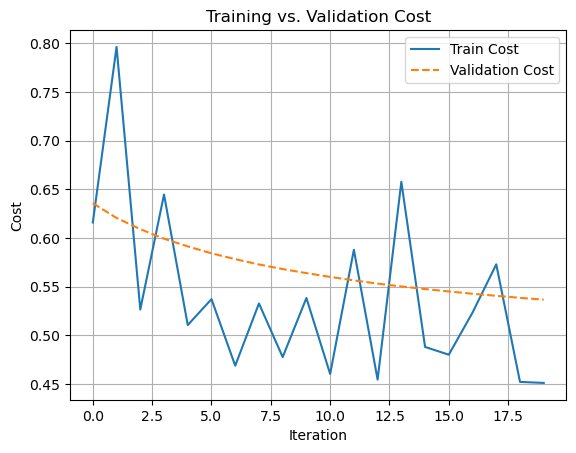

In [808]:
def compute_cost(A, Y, W , regularizer):
    epsilon = 1e-10  # Small value to prevent log(0)
    A = np.clip(A, epsilon, 1 - epsilon)
    m = Y.shape[1]
    cost = -1.0/m*np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))
    if regularizer['name'] == 'l2':
        lambd = regularizer['lambd']
        cost = cost + lambd/(2*m)*np.sum(np.square(W))
    cost = np.squeeze(np.array(cost))
    return cost

def sigmoid(Z):
    return np.where(Z >= 0,  1 / (1 + np.exp(-Z)), np.exp(Z) / (1 + np.exp(Z)) )

def forward(X, W, b):
    '''
    X: input data (n_x, m)
    W weights (1, n_x), a row is weights for all features
    b bias (1, 1), broadcasting will be applied
    '''
    Z = np.dot(W, X) + b
    A = sigmoid(Z)
    return A

def compute_grad(A,Y,X,W,b,regularizer):
    '''
    Z: output of the forward pass (1, m)
    Y: true label (1, m)
    X: input data (n_x, m)
    # with sigmoid activation function
    '''
    name = regularizer['name']

    m = A.shape[1]
    dZ = A-Y
    dW = 1.0/m*np.dot(dZ, X.T)
    db = 1.0/m*np.sum(dZ)

    if name == 'l2':
        lambd = regularizer['lambd']
        dW = dW + lambd/m*W
    return (dW, db)

def update_params(W,b, grad, alpha = 0.001, optimizer =None, m = None, v = None, k = 0):
    '''
    m: shape of W
    v: shape of W
    '''
    (dW, db) = grad
    
    optmz = optimizer['name']

    if optmz == 'adam':
        epsilon = 1e-8
        beta1 = optimizer['beta1']
        beta2 = optimizer['beta2']
        m = (1-beta1)*dW +beta1*m
        v = (1-beta2)*dW**2 + beta2*v
        m_hat = m/(1-beta1**k)
        v_hat = v/(1-beta2**k)
        W = W - alpha*m_hat/(np.sqrt(v_hat)+epsilon)
        b = b - alpha*db
        return (W,b,m,v)
    elif optmz == 'momentum':
        beta = optimizer['beta']
        v = beta*v + alpha*dW
        W = W - v
        b = b - alpha*db
        return (W,b,v)
    else:
        W = W - alpha*dW
        b = b - alpha*db
        return (W,b)
    

def initialize_params(n_x):
    W = np.random.randn(1, n_x) * 0.01
    b = np.zeros((1,1))
    return W,b

def model(X,Y,n_itrs = 100000,regularizer ='l2', optimizer=None, lambd = 0.7, print_cost = True, validate = True, X_val = None, Y_val = None):
    '''
    X: input data (n_x, m)
    Y: true label (1, m)
    n_itrs: number of iterations
    regularizer: regularization method
    optimizer: optimizer method
    '''
    #initialize parameters
    costs = []
    val_costs = []
    (n_x,m) = X.shape
    W,b = initialize_params(n_x)
    optmz = optimizer['name']
    learning_rate = optimizer['learning_rate']
    
    if optmz == 'adam':
        m = np.zeros_like(W)
        v = np.zeros_like(W)
    elif optmz == 'momentum':
        v = np.zeros_like(W)
    
    #train
    if optmz == 'sgd':
        W_list = [W]
        b_list = [b]
        check_w_after = 20
        tol = 1e-5
        count  = 0
        while count < n_itrs:
            batch_size = 32  # Try different values like 16, 64
            mix_id = np.random.permutation(m)

            for i in range(0, m, batch_size):
                batch_ids = mix_id[i:i + batch_size]
                X_batch = X[:, batch_ids]
                Y_batch = Y[:, batch_ids]

                A = forward(X_batch, W_list[-1], b_list[-1])
                grad = compute_grad(A, Y_batch, X_batch, W_list[-1], b_list[-1], regularizer)
                W_new, b_new = update_params(W_list[-1], b_list[-1], grad, learning_rate, optimizer={'name': 'normal'})

                W_list.append(W_new)
                b_list.append(b_new)
                count += 1

                if count % check_w_after == 0:
                    if print_cost and count % 1000 == 0:
                        cost = compute_cost(A,Y_batch,W_new, regularizer)
                        costs.append(cost)  # Store cost
                        print(f'Cost after {count} iterations: {cost}')
                        if validate:
                            A_val = forward(X_val,W_new,b_new)
                            val_cost = compute_cost(A_val,Y_val,W_new,regularizer)
                            val_costs.append(val_cost)
                            print(f'Validation Cost after {count} iterations: {val_cost}')

                    if np.linalg.norm(W_new - W_list[-check_w_after]) < tol:
                        print(f"Converged after {count} updates.")
                        return W_list[-1],b_list[-1], costs, val_costs

        return W_list[-1],b_list[-1], costs, val_costs
    
    for i in range(n_itrs):
    
        A= forward(X,W,b)
        # print(np.min(A), np.max(A))
        cost = compute_cost(A,Y,W, regularizer)
        grad = compute_grad(A,Y,X,W,b,regularizer)
        if optmz == 'adam':
            W,b,m,v= update_params(W,b,grad,learning_rate, optimizer, k = i+1, m = m, v = v)
        elif optmz == 'momentum':
            W,b,v= update_params(W,b,grad,learning_rate, optimizer, v = v)
        else:
            W,b= update_params(W,b,grad,learning_rate, optimizer)
        costs.append(cost)
        if validate:
                A_val = forward(X_val,W,b)
                val_cost = compute_cost(A_val,Y_val,W, regularizer)
                val_costs.append(val_cost)
        if i % 1000 == 0:
            print(f'Cost after {i} iterations: {cost}')
            # if validate:
                # print(f'Validation Cost after {i} iterations: {val_cost}')
    return W,b,costs, val_costs


def predict(X,W,b):
    A = forward(X,W,b)
    m = X.shape[1]
    Y_prediction = np.zeros((1, m),dtype=int)
    for i in range(A.shape[1]):
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
    return Y_prediction

np.random.seed(44)
adam_optimizer = {'name':'adam','beta1':0.9, 'beta2':0.999, 'learning_rate':0.005}
l2_regularizer = {'name':'l2', 'lambd':0.7}
sgd_optimizer = {'name':'sgd', 'learning_rate':0.001}
normal_optimizer = {'name':'normal', 'learning_rate':0.01}
momentum_optimizer = {'name':'momentum', 'beta':0.92, 'learning_rate':0.008}
#best: sgd 0.001, l2 0.7, n_itrs = 40000
W,b,costs,val_costs= model(X_train,Y_train, n_itrs = 20000 , regularizer=l2_regularizer, optimizer=sgd_optimizer, validate = True, Y_val = Y_val, X_val = X_val)
plot_costs(costs,val_costs)

In [809]:
predictions_train = predict(X_train,W,b)
accuracy_train = 100 - np.mean(np.abs(predictions_train - Y_train)) * 100
predictions_val = predict(X_val,W,b)
accuracy_val = 100 - np.mean(np.abs(predictions_val - Y_val)) * 100

In [810]:
print(f"Train Accuracy: {accuracy_train}")
print(f"Validation Accuracy: {accuracy_val}")

Train Accuracy: 77.9494382022472
Validation Accuracy: 73.74301675977654


In [811]:
predict_test = predict(test2.T,W,b)
predict_test = predict_test.reshape(-1)
submission = pd.DataFrame({'PassengerId': passenger_id, 'Survived': predict_test})
submission.to_csv('submission.csv', index=False)

## Result
Top 25% (2908/15263) with score of 0.78229

In [800]:
img_path = 'lab6_2_result.png'
if not os.path.exists(img_path):
    url = f'{based_url}1fBBpHZKRpJ2f8lxTwPLk8m8iipMGDA7Z'
    gdown.download(url, img_path, quiet=False)
img = Image.open(img_path)
img.show()

Downloading...
From: https://drive.google.com/uc?id=1fBBpHZKRpJ2f8lxTwPLk8m8iipMGDA7Z
To: d:\Python\NLP\lab6\lab6_2_result.png
100%|██████████| 160k/160k [00:00<00:00, 1.06MB/s]
